In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

location = "remote"
if location == "remote":
    # TODO: hacky, shouldn't be necessary
    os.environ["WANDB_NOTEBOOK_NAME"] = "lustre_scratch/coralshift/notebooks/rnn.ipynb"
    os.chdir("/lustre_scratch/orlando-code/coralshift/")


In [2]:
from __future__ import annotations

from pathlib import Path
import xarray as xa
import numpy as np
import math as m
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import wandb
from tqdm import tqdm
from sklearn import model_selection
from sklearn.preprocessing import normalize
from scipy.interpolate import interp2d
from sklearn.utils import class_weight

import rasterio
from rasterio.plot import show
import rioxarray as rio

#issues with numpy deprecation in pytorch_env
from coralshift.processing import spatial_data
from coralshift.utils import file_ops, directories
from coralshift.plotting import spatial_plots, model_results
from coralshift.dataloading import data_structure, climate_data

2023-06-05 21:41:20.679158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load in data

In [3]:
ds_man = data_structure.MyDatasets()
ds_man.set_location(location)

noaa_features = ['mlotst', 'bottomT', 'uo', 'so', 'zos', 'thetao', 'vo']

# TODO: transparency in preprocessing to get to this (probably split into separate gt datarray)
ds_man.add_dataset(
    "monthly_climate_1_12", xa.open_dataset(
        ds_man.get_location() / "global_ocean_reanalysis/monthly_means/coral_climate_1_12.nc")
)

ds_man.add_dataset(
    "monthly_climate_features", ds_man.get_dataset("monthly_climate_1_12")[noaa_features]
)

# ds_man.add_dataset(
#     "monthly_climate_1_12_X_y_np", spatial_data.filter_out_nans(
#         spatial_data.xa_ds_to_3d_numpy(ds_man.get_dataset("monthly_climate_1_12")), 
#         np.array(ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"].isel(time=-1)).reshape(-1, 1))
# )
ds_man.add_datasets(
    ["monthly_climate_1_12_X", "monthly_climate_1_12_y"], 
        spatial_data.process_xa_ds_for_ml(ds_man.get_dataset("monthly_climate_1_12"), 
        feature_vars=noaa_features, gt_var="coral_algae_1-12_degree")
)

# TODO: handle depth
ds_man.add_dataset(
    "daily_climate_1_12", spatial_data.generate_and_add_gt_to_xa_d(xa.open_dataset(
        Path(ds_man.get_location() / "global_ocean_reanalysis/daily_means/dailies_combined.nc")).isel(depth=0),
        ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"])
)

# TODO: streamline checking and saving process
daily_climate_1_12_X_file_path = ds_man.get_location() / "global_ocean_reanalysis/daily_means/daily_climate_1_12_X.npy"
# if daily_climate_1_12_X numpy array doesn't exist, generate and save
if not file_ops.check_file_exists(filepath = daily_climate_1_12_X_file_path):
    daily_climate_1_12_X = spatial_data.process_xa_ds_for_ml(ds_man.get_dataset("daily_climate_1_12"),
        feature_vars = noaa_features)
    np.save(daily_climate_1_12_X_file_path, daily_climate_1_12_X) 
    ds_man.add_dataset("daily_climate_1_12_X", np.load(daily_climate_1_12_X_file_path))
else:
    ds_man.add_dataset("daily_climate_1_12_X", np.load(daily_climate_1_12_X_file_path))

# daily_climate_1_12_padded_1_file_path = ds_man.get_location() / "global_ocean_reanalysis/daily_means/daily_climate_1_12_padded_1.nc"
# # if daily_climate_1_12_padded numpy array doesn't exist, generate and save
# if not file_ops.check_file_exists(filepath = daily_climate_1_12_padded_1_file_path):
#     daily_climate_1_12_padded_1 = spatial_data.spatially_buffer_timeseries(
#         ds_man.get_dataset("daily_climate_1_12"), buffer_size=1, exclude_vars = ["spatial_ref", "coral_algae_gt"])
#     daily_climate_1_12_padded_1.to_netcdf(filepath = daily_climate_1_12_padded_1_file_path)
#     ds_man.add_dataset("daily_climate_1_12_padded_1", xa.open_dataset(daily_climate_1_12_padded_1_file_path))
# else:
#     ds_man.add_dataset("daily_climate_1_12_padded_1", xa.open_dataset(daily_climate_1_12_padded_1_file_path))

ds_man.add_dataset(
    "bathymetry_A", rio.open_rasterio(
        rasterio.open(ds_man.get_location() / "bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif"),
        ).rename("bathymetry_A").rename({"x": "longitude", "y": "latitude"})
)

In [53]:
def visualise_variable_in_region(
    xa_array: xa.DataArray, lat_lims: tuple[float, float]=None, lon_lims: tuple[(float, float)]=None) -> None:
    
    fig, ax = plt.subplots(1,3, figsize=[15,5], 
        # sharey=True,
        gridspec_kw={'width_ratios': [1, 2, 1]})

    if lat_lims is not None:
        xa_array = xa_array.sel(latitude=slice(min(lat_lims), max(lat_lims)), longitude=slice(min(lon_lims), max(lon_lims)))
    
    flat_data = xa_array.values.flatten()
    spatial_mean = xa_array.mean(dim=["latitude","longitude"])
    ax[0].boxplot(spatial_mean)
    spatial_mean.plot.line(ax=ax[1])
    spatial_mean.plot.hist(ax=ax[2])

    # format
    ax[0].set_ylabel(xa_array.name)
    ax[1].set_xlabel("time")

    return spatial_mean



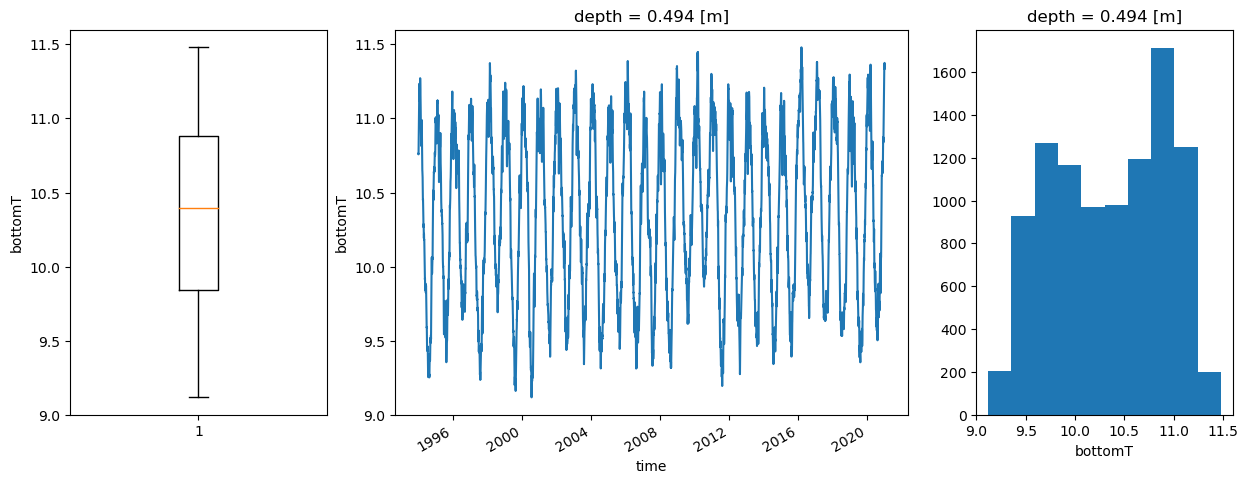

In [55]:
dailies = ds_man.get_dataset("daily_climate_1_12")
sm = visualise_variable_in_region(dailies["bottomT"])


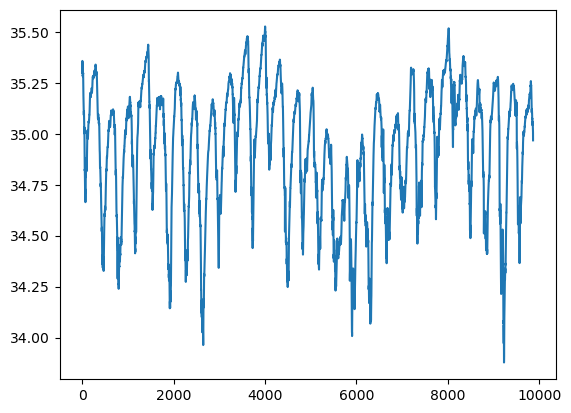

In [47]:
var_data = dailies["so"]
flat = var_data.values.flatten()
# plt.boxplot(flat)
spatial_mean = var_data.mean(dim=["latitude","longitude"])
plt.plot(spatial_mean)


In [5]:
# ds_man.get_dataset("daily_climate_1_12")
# ds_man.get_dataset("monthly_climate_1_12")
test = xa.open_dataset(
        ds_man.get_location() / "global_ocean_reanalysis/monthly_means/coral_climate_1_12.nc")

Calculating area within range: 100%|██████████| 6324/6324 [00:00<00:00, 33118.26it/s]


([((0, 24), (1, 25)),
  ((0, 26), (1, 27)),
  ((0, 28), (1, 29)),
  ((0, 30), (1, 31)),
  ((0, 32), (1, 33)),
  ((0, 34), (1, 35)),
  ((0, 36), (1, 37)),
  ((0, 38), (1, 39)),
  ((0, 40), (1, 41)),
  ((0, 42), (1, 43)),
  ((0, 44), (1, 45)),
  ((0, 46), (1, 47)),
  ((0, 48), (1, 49)),
  ((0, 50), (1, 51)),
  ((0, 52), (1, 53)),
  ((0, 54), (1, 55)),
  ((0, 56), (1, 57)),
  ((0, 58), (1, 59)),
  ((0, 60), (1, 61)),
  ((0, 86), (1, 87)),
  ((0, 88), (1, 89)),
  ((0, 90), (1, 91)),
  ((0, 92), (1, 93)),
  ((0, 94), (1, 95)),
  ((0, 96), (1, 97)),
  ((0, 98), (1, 99)),
  ((0, 100), (1, 101)),
  ((0, 102), (1, 103)),
  ((0, 104), (1, 105)),
  ((0, 106), (1, 107)),
  ((0, 108), (1, 109)),
  ((0, 110), (1, 111)),
  ((0, 112), (1, 113)),
  ((0, 114), (1, 115)),
  ((0, 116), (1, 117)),
  ((0, 118), (1, 119)),
  ((0, 120), (1, 121)),
  ((0, 122), (1, 123)),
  ((0, 124), (1, 125)),
  ((0, 126), (1, 127)),
  ((0, 128), (1, 129)),
  ((0, 130), (1, 131)),
  ((0, 132), (1, 133)),
  ((0, 134), (1, 135

In [32]:
import sqlite3

In [34]:
con.cursor()

NameError: name 'con' is not defined

In [44]:
con = sqlite3.connect("lustre_scratch/datasets/bleaching/Global_Coral_Bleaching_Database_SQLite_11_24_21.db")
cur = con.execute("SELECT name FROM sqlite_master WHERE type='table';")


In [45]:
table_names = [row[0] for row in cur.fetchall()]
table_names


['Authors_LUT',
 'Bleaching_Level_LUT',
 'Bleaching_Prevalence_Score_LUT',
 'Bleaching_tbl',
 'City_Town_Name_LUT',
 'Country_Name_LUT',
 'Cover_tbl',
 'Data_Source_LUT',
 'Ecoregion_Name_LUT',
 'Environmental_tbl',
 'Exposure_LUT',
 'Ocean_Name_LUT',
 'R_Scripts_tbl',
 'Realm_Name_LUT',
 'Sample_Event_tbl',
 'Severity_Code_LUT',
 'Site_Info_tbl',
 'State_Island_Province_Name_LUT',
 'Substrate_Type_LUT',
 'Query_2_Sample_Event_Counts',
 'Query_3_Time_Series',
 'Query_4_Samples_by_Data_Source',
 'Query_5_Sites_by_Data_Source',
 'Query_6_Sites_with_Multiple_Sample_Events',
 'Subquery_1_Sites_and_Sample_Events',
 'Subquery_6_Calculated_Reef_Check_Segments']

In [55]:
daily_climate_1_12_padded_1 = ds_man.get_dataset("daily_climate_1_12_padded_1")

In [56]:
daily_climate_1_12_padded_1

<xarray.Dataset>
Dimensions:    (latitude: 85, time: 9863, longitude: 61)
Coordinates:
  * latitude   (latitude) float32 -17.0 -16.92 -16.83 ... -10.17 -10.08 -10.0
  * time       (time) datetime64[ns] 1993-12-31T12:00:00 ... 2020-12-31T12:00:00
  * longitude  (longitude) float32 142.0 142.1 142.2 142.2 ... 146.8 146.9 147.0
    depth      float32 ...
Data variables:
    bottomT    (time, latitude, longitude) float32 ...
    mlotst     (time, latitude, longitude) float32 ...
    so         (time, latitude, longitude) float32 ...
    thetao     (time, latitude, longitude) float32 ...
    uo         (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...

In [30]:
np.diff(spatial_data.xarray_coord_limits(daily_climate_1_12_padded_1, "latitude")).item()

7.0

In [46]:
padded = ds_man.get_dataset("daily_climate_1_12_padded_1")
gt = ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"]

In [51]:
dailies = generate_and_add_gt_to_xa_d(padded, gt)

In [27]:
coral_gt, _ = spatial_data.sample_spatial_batch(
       ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"], 
       lat_lon_starts=(-10,141.95), coord_range=(-7.01,5.11))
daily_climate_1_12 = ds_man.get_dataset("daily_climate_1_12")

spatial_data.add_gt_to_xa_d(daily_climate_1_12, coral_gt)


<xarray.Dataset>
Dimensions:         (latitude: 85, time: 9863, longitude: 61)
Coordinates:
  * latitude        (latitude) float32 -17.0 -16.92 -16.83 ... -10.08 -10.0
  * time            (time) datetime64[ns] 1993-12-31T12:00:00 ... 2020-12-31T...
  * longitude       (longitude) float32 142.0 142.1 142.2 ... 146.8 146.9 147.0
    depth           float32 0.494
Data variables:
    bottomT         (time, latitude, longitude) float32 ...
    mlotst          (time, latitude, longitude) float32 ...
    so              (time, latitude, longitude) float32 ...
    thetao          (time, latitude, longitude) float32 ...
    uo              (time, latitude, longitude) float32 ...
    vo              (time, latitude, longitude) float32 ...
    zos             (time, latitude, longitude) float32 ...
    coral_algae_gt  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/25)
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2022/05/25 21:54:07 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              5727.917
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

In [28]:
# coral_gt, lat_lon_A_vals_dict = spatial_data.sample_spatial_batch(
#        ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"], 
#        lat_lon_starts=(-10,141.95), coord_range=(-7.01,5.11))
# daily_climate_1_12 = ds_man.get_dataset("daily_climate_1_12")

# coral_gt = coral_gt.isel(latitude=slice(None, None, -1))
# # daily_climate_1_12["coral_algae_1-12_degree"] = coral_gt

# expanded_data_array = np.tile(coral_gt.isel(time=0), (len(list(daily_climate_1_12.time.values)), 1, 1))
# daily_climate_1_12['coral_algae_1-12_degree'] = (('time', 'latitude', 'longitude'), expanded_data_array)


ds_man.add_dataset("daily_climate_1_12", daily_climate_1_12)

## GRU function definitions 

In [ ]:
xa_coral_climate_1_12_features = ds_man.get_dataset("monthly_climate_features")
xa_coral_climate_1_12 = ds_man.get_dataset("monthly_climate_1_12")

xa_coral_climate_1_12_working = xa_coral_climate_1_12

In [ ]:
# all_Xs_onehot, all_lat_lon_dict_onehot = sample_spatial_batch(xa_coral_climate_1_12, lat_lon_starts=(-8,140), coord_range=(-20,13))
# all_Xs_onehot, all_lat_lon_dict_onehot = subsample_to_array(xa_coral_climate_1_12, lat_lon_starts=(-8,140), coord_range=((-20,13)))
# all_Xs_onehot = naive_X_nan_replacement(all_Xs_onehot)
# all_ys_onehot, _ = subsample_to_array(xa_coral_climate_1_12, lat_lon_starts=(-8,140), coord_range=(-20,13), variables = ["coral_algae_1-12_degree"])
# all_ys_onehot = naive_y_nan_replacement(all_ys_onehot)
# all_ys_onehot = all_ys_onehot[:,:,0]

train_onehot_Xs, train_onehot_ys, train_onehot_subsample, train_onehot_lat_lons_vals_dict = generate_patch(xa_ds=xa_coral_climate_1_12, lat_lon_starts=(-10,142), coord_range=(-6,6), onehot=False)
test_onehot_Xs, test_onehot_ys, test_onehot_subsample, test_onehot_lat_lons_vals_dict = generate_patch(xa_ds=xa_coral_climate_1_12, lat_lon_starts=(-16,148), coord_range=(-6,6))

print("train_onehot_Xs shape: ", train_onehot_Xs.shape)
print("train_onehot_ys shape: ", train_onehot_ys.shape)

In [64]:
# load bathymetry
bath_A = ds_man.get_dataset("bathymetry_A")
bath_A

<xarray.DataArray 'bathymetry_A' (band: 1, latitude: 23333, longitude: 16666)>
[388867778 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 147.0 147.0 147.0
  * latitude     (latitude) float64 -10.0 -10.0 -10.0 ... -17.0 -17.0 -17.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': ' DEM upsampled to 1000 meters'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f731434b130>)

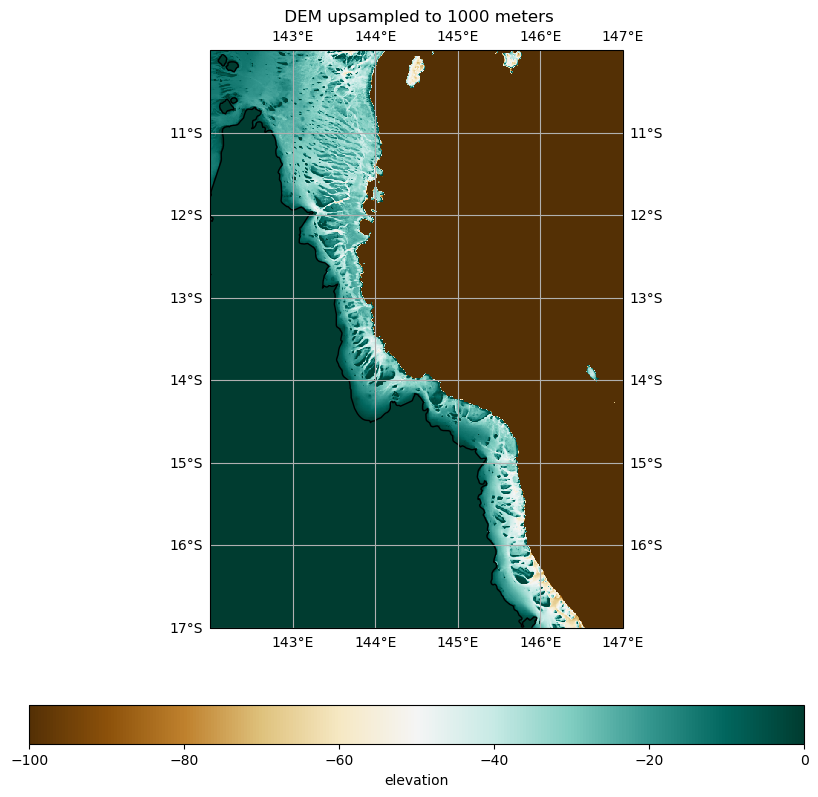

In [65]:

# 1 km. Struggles displaying/processing 100m, but have yet to try saving to this/inferring
target_resolution = 1000
_,_,av_degrees = spatial_data.distance_to_degrees(target_resolution)
bath_A_1km = spatial_data.upsample_xarray_to_target(bath_A, av_degrees)
# im = bath_A_1km.plot(ax=ax)

spatial_plots.plot_DEM(bath_A_1km, f" DEM upsampled to {target_resolution} meters", vmin=-100, vmax=0)
# spatial_plots.format_spatial_plot(im, fig, ax, f"Upsampled to {target_resolution} degrees")

In [19]:
def find_chunks_with_percentage(
    array: np.ndarray,
    range_min: float,
    range_max: float,
    chunk_size: int,
    threshold_percent: float,
    preprocess: bool = True
) -> list[tuple[float, float]]:
    """Find chunks in the array that contain a certain threshold percentage of pixel values within a specified range.

    Parameters
        array (ndarray): Input array.
        range_min (float): Minimum value for the range.
        range_max (float): Maximum value for the range.
        chunk_size (int): Size of the chunks in rows and columns.
        threshold_percent (float): Threshold percentage for chunk selection.

    Returns:
        tuple[list[tuple[float, float]], list[float]]: List of chunk coordinates that meet the threshold percentage
            criteria and list of percentage of grid cells meeting criteria.
    """
    if preprocess:
        array = preprocess_array(array, range_min, range_max)

    # to make chunk_size behave as expected in the face of non-inclusive final indices
    chunk_size = chunk_size + 1
    rows, cols = array.shape
    chunk_rows = np.arange(0, rows - chunk_size, chunk_size)
    chunk_cols = np.arange(0, cols - chunk_size, chunk_size)

    chunk_coords = []
    cell_coverages = []

    for start_row in tqdm(chunk_rows, desc="Calculating areas within value range"):
        for start_col in chunk_cols:
            # Calculate the sub-array within the chunk
            sub_array = array[start_row:start_row + chunk_size, start_col:start_col + chunk_size]

            # Count the number of values within the range
            count = np.sum((sub_array >= range_min) & (sub_array <= range_max))

            # Calculate the coverage percentage
            cell_coverage = (count / (chunk_size ** 2)) * 100

            if cell_coverage >= threshold_percent:
                chunk_coords.append(
                    (
                        (start_row, start_col),
                        (start_row + chunk_size - 1, start_col + chunk_size - 1),
                    )
                )
                cell_coverages.append(cell_coverage.item())

    return chunk_coords, cell_coverages


def preprocess_array(array: np.ndarray, range_min: float, range_max: float) -> np.ndarray:
    """
    Preprocess the input array by filtering out values outside the desired range.

    Parameters:
        array (ndarray): Input array.
        range_min (float): Minimum value for the desired range.
        range_max (float): Maximum value for the desired range.

    Returns:
        ndarray: Preprocessed array with values filtered within the desired range.
    """
    return np.where(np.logical_and(array >= range_min, array <= range_max), array, np.nan)



def nc_chunk_files(
    dest_dir_path: Path | str,
    xa_ds: xa.Dataset,
    chunk_size: int = 20,
    threshold_percent: float = 10,
    vmin: float = -100,
    vmax: float = 0,
):
    """Save chunks of an xarray Dataset to NetCDF files along with accompanying metadata JSON files.

    Parameters
    ----------
    dest_dir_path (Path | str): Directory path to save the chunk files.
    xa_ds (xa.Dataset): Input xarray Dataset.
    chunk_size (int, optional): Size of the chunks (default is 20).
    threshold_percent (float, optional): Threshold percentage for chunk coverage (default is 10).
    vmin (float, optional): Minimum value for chunk selection (default is -100).
    vmax (float, optional): Maximum value for chunk selection (default is 0).

    Returns
    -------
    None
    """

    chunk_coord_pairs, coverages = find_chunks_with_percentage(
        xa_ds.values, vmin, vmax, chunk_size, threshold_percent
    )

    for i, coord_pair in tqdm(
        enumerate(chunk_coord_pairs),
        desc="Saving chunks .nc and accompanying metadata .json files",
        total=len(chunk_coord_pairs),
    ):
        sub_ds = spatial_data.ds_subsample_from_coord(xa_ds, coord_pair)
        # generate filename and file_path
        filename = "_".join(
            ("chunk", utils.pad_number_with_zeros(number=i, resulting_len=3))
        )
        file_path = Path(dest_dir_path) / filename
        # generate chunk metadata
        info_dict = generate_chunk_json(sub_ds, file_path, coord_pair, coverages[i])
        # save metadata file
        file_ops.save_json(
            info_dict, filepath=file_path.with_suffix(".json"), verbose=False
        )
        # save nc file
        sub_ds.to_netcdf(path=file_path.with_suffix(".nc"))

    print(f".nc chunk files and accompanying metadata written to {str(dest_dir_path)}")
    return chunk_coord_pairs, coverages


def add_data_to_chunk(xa_chunk_data, xa_new_data, interp_method: str="nearest", broadcast: bool=True):
    # TODO: add in checking about relative resolutions
    interped = xa_new_data.interp(
        latitude=xa_chunk_data["latitude"], longitude=xa_chunk_data["longitude"], method=interp_method)
    # TODO: issue with time broadcasting?
    merged_ds = xa.combine_by_coords([xa_chunk_data, interped], coords=['latitude', 'longitude', 'time'], join="inner")
    if broadcast:
        (merged_ds,) = xa.broadcast(merged_ds)
    return merged_ds
    # save file


def add_data_to_chunks(chunk_paths: list[Path | str], xa_new_data_area, new_dir_name: str):
    # determine chunk_paths folder
    chunk_dir = Path(Path(chunk_paths[0]).parent)
    # make new folder for writing merged data to
    new_dir = file_ops.guarantee_existence(chunk_dir / new_dir_name)

    for p in tqdm(chunk_paths, desc="Merging additional data into .nc chunk files"):
        p = Path(p)
        chunk_file_name = p.stem
        new_chunk_path = new_dir / p.stem
        xa_chunk_data = xa.open_dataset(p)
        # determine spatial limts TODO: could replace this with reading from metadata (potentially faster)
        lat_lims = spatial_data.xarray_coord_limits(xa_chunk_data, "latitude") 
        lon_lims = spatial_data.xarray_coord_limits(xa_chunk_data, "longitude")
        # TODO: make selection of index order more universal (currently only good for negative lats)
        extra_xa_chunk_data = xa_new_data_area.sel({
            "latitude": slice(lat_lims[0], lat_lims[1]),
            "longitude": slice(lon_lims[0], lon_lims[1])
            })

        # determine data to add TODO: change
        merged_ds = add_data_to_chunk(xa_chunk_data, extra_xa_chunk_data)
        info_dict = generate_chunk_json(merged_ds, new_chunk_path)
        file_ops.save_json(info_dict, filepath=new_chunk_path.with_suffix(".json"), verbose=False)
        merged_ds.to_netcdf(path=new_chunk_path.with_suffix(".nc"))
    print(f"Merged chunks written to .nc files at {str(new_dir)}")

def generate_chunk_json(
    xa_d: xa.DataArray,
    file_path: str | Path,
    coord_pair: tuple[int] = None,
    coverage: float = None,
) -> dict:
    """Generate metadata JSON dictionary for a chunk of an xarray DataArray.

    Parameters
    ----------
    xa_d (xa.DataArray): Input xarray DataArray.
    file_path (str | Path): File path of the chunk.
    coord_pair (tuple[int]): Index pair containing the start and end coordinates.
    coverage (float): Chunk coverage value.

    Returns
    -------
    dict: Metadata JSON dictionary.
    """

    # TODO: make robust with different dataset/dataarray

    # make filename
    vars = spatial_data.get_vars_from_ds_or_da(xa_d)
    # convert coord indices to absolute coords (TODO: could add spatial functionality for chunking)
    lat_lims = spatial_data.xarray_coord_limits(xa_d, "latitude")
    lon_lims = spatial_data.xarray_coord_limits(xa_d, "longitude")
    # find resolution
    lat_resolution_d, lon_resolution_d = spatial_data.calculate_spatial_resolution(xa_d)
    lat_resolution_m, lon_resolution_m = spatial_data.degrees_to_distances(
        lat_resolution_d, lon_resolution_d
    )


    info_dict = {
        "file name": file_path.stem,
        "file path": str(file_path),
        "variables": vars,
        "latitude range": lat_lims,
        "longitude range": lon_lims,
        "latitude resolution (degrees)": lat_resolution_d,
        "longitude resolution (degrees)": lon_resolution_d,
        "latitude resolution (meters)": lat_resolution_m,
        "longitude resolution (meters)": lon_resolution_m,
    }

    if coord_pair is not None:
        # calculate minimum and maximum bathymetries
        min_bath, max_bath = xa_d.values.min(), xa_d.values.max()
        additional_info = {
            "latitude chunk size": np.diff((coord_pair[0][0], coord_pair[1][0])).item(),
            "longitude chunk size": np.diff(
                (coord_pair[0][1], coord_pair[1][1])
            ).item(),
            "start index pair": coord_pair[0],
            "end index pair": coord_pair[1],
            "minimum bathymetry": min_bath,
            "maximum bathymetry": max_bath,
        }
        info_dict.update(additional_info)
    if coverage is not None:
        additional_info = {
            "cell coverage": coverage,
        }
        info_dict.update(additional_info)

    return info_dict

In [308]:
Path("lustre_scratch/datasets/test/chunk_000.nc").parent

PosixPath('lustre_scratch/datasets/test')

In [364]:
daily_climate_1_12

<xarray.Dataset>
Dimensions:         (latitude: 85, time: 9863, longitude: 61)
Coordinates:
  * latitude        (latitude) float32 -17.0 -16.92 -16.83 ... -10.08 -10.0
  * time            (time) datetime64[ns] 1993-12-31T12:00:00 ... 2020-12-31T...
  * longitude       (longitude) float32 142.0 142.1 142.2 ... 146.8 146.9 147.0
    depth           float32 0.494
Data variables:
    bottomT         (time, latitude, longitude) float32 ...
    mlotst          (time, latitude, longitude) float32 ...
    so              (time, latitude, longitude) float32 ...
    thetao          (time, latitude, longitude) float32 ...
    uo              (time, latitude, longitude) float32 ...
    vo              (time, latitude, longitude) float32 ...
    zos             (time, latitude, longitude) float32 ...
    coral_algae_gt  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/25)
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2022/05/25 21:54:07 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              5727.917
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

In [20]:
add_data_to_chunks(["lustre_scratch/datasets/test/chunk_000.nc"], daily_climate_1_12_padded_1, "padded_climate_chunks")

Merging additional data into .nc chunk files: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]

Merged chunks written to .nc files at /lustre_scratch/orlando-code/datasets/test/padded_climate_chunks


In [24]:
daily_climate_1_12_padded_1

<xarray.Dataset>
Dimensions:    (latitude: 85, time: 9863, longitude: 61)
Coordinates:
  * latitude   (latitude) float32 -17.0 -16.92 -16.83 ... -10.17 -10.08 -10.0
  * time       (time) datetime64[ns] 1993-12-31T12:00:00 ... 2020-12-31T12:00:00
  * longitude  (longitude) float32 142.0 142.1 142.2 142.2 ... 146.8 146.9 147.0
    depth      float32 ...
Data variables:
    bottomT    (time, latitude, longitude) float32 ...
    mlotst     (time, latitude, longitude) float32 ...
    so         (time, latitude, longitude) float32 ...
    thetao     (time, latitude, longitude) float32 ...
    uo         (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...

In [23]:
merged = xa.open_dataset("lustre_scratch/datasets/test/padded_climate_chunks/chunk_000.nc")
merged

<xarray.Dataset>
Dimensions:       (longitude: 20, latitude: 20, time: 9863)
Coordinates:
    spatial_ref   int64 ...
    depth         float32 ...
    band          int64 ...
  * longitude     (longitude) float64 142.0 142.0 142.0 ... 142.2 142.2 142.2
  * latitude      (latitude) float64 -10.0 -10.01 -10.02 ... -10.17 -10.18
  * time          (time) datetime64[ns] 1993-12-31T12:00:00 ... 2020-12-31T12...
Data variables:
    bathymetry_A  (longitude, latitude, time) float32 ...
    bottomT       (longitude, latitude, time) float32 ...
    mlotst        (longitude, latitude, time) float32 ...
    so            (longitude, latitude, time) float32 ...
    thetao        (longitude, latitude, time) float32 ...
    uo            (longitude, latitude, time) float32 ...
    vo            (longitude, latitude, time) float32 ...
    zos           (longitude, latitude, time) float32 ...

In [22]:
merged["coral_algae_gt"].isel(time=0).plot()
# merged["bathymetry_A"].plot()

KeyError: 'coral_algae_gt'

In [378]:
chunk_coord_pairs, _ = nc_chunk_files("lustre_scratch/datasets/test", bath_A_1km.isel(band=0))

Calculating areas within value range: 100%|██████████| 37/37 [00:00<00:00, 1172.34it/s]
Saving chunks .nc and accompanying metadata .json files: 100%|██████████| 219/219 [00:04<00:00, 45.85it/s]

.nc chunk files and accompanying metadata written to lustre_scratch/datasets/test


/tmp/ipykernel_8262/326528260.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipykernel_8262/326528260.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.set_ticklabels(np.arange(0, len(chunk_coord_pairs), 50))


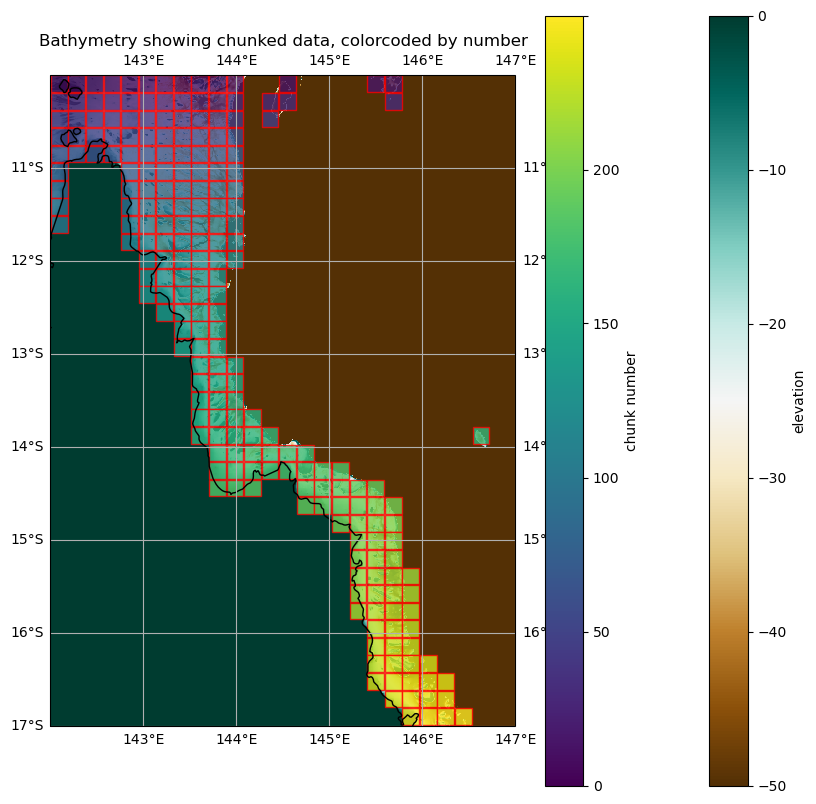

In [379]:
da = bath_A_1km
_, ax, _ = spatial_plots.plot_DEM(da, "Bathymetry showing chunked data, colorcoded by number", orient_colorbar="vertical")

cmap = plt.cm.get_cmap('viridis')
for i, coord in enumerate(chunk_coord_pairs):
    color = cmap(i / len(chunk_coord_pairs))

    xy = spatial_data.index_to_coord(da, coord[0])
    height, width = spatial_data.delta_index_to_distance(da, coord[1], coord[0])
    rect = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor=color, alpha=0.8)
    ax.add_patch(rect)

cbar2 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, orientation='vertical', label="chunk number")
cbar2.set_ticklabels(np.arange(0, len(chunk_coord_pairs), 50))

plt.show()

In [274]:
test_chunk

<xarray.Dataset>
Dimensions:       (longitude: 20, latitude: 20)
Coordinates:
    band          int64 ...
  * longitude     (longitude) float64 142.0 142.0 142.0 ... 142.2 142.2 142.2
  * latitude      (latitude) float64 -10.0 -10.01 -10.02 ... -10.17 -10.18
    spatial_ref   int64 ...
Data variables:
    bathymetry_A  (latitude, longitude) float32 ...

In [298]:
lat_lims

(-10.175638888905807, -10.00463888890581)

In [299]:
restricted_bath = bath_A_1km.sel({
    "latitude": slice(lat_lims[1], lat_lims[0]),
    "longitude": slice(lon_lims[0], lon_lims[1])
})
restricted_bath

<xarray.DataArray 'bathymetry_A' (band: 1, latitude: 20, longitude: 20)>
array([[[-1.14498243e+01, -1.11824598e+01, -1.14184322e+01,
         -1.15840492e+01, -1.19023304e+01, -1.21552744e+01,
         -1.22366676e+01, -1.18710318e+01, -9.98563385e+00,
         -6.91362619e+00, -5.65264940e+00, -5.33874989e+00,
         -6.13572407e+00, -5.42662334e+00, -4.42890120e+00,
         -3.00057173e+00, -2.53456044e+00, -3.26254916e+00,
         -3.51394224e+00, -3.33518410e+00],
        [-1.11172190e+01, -1.12474308e+01, -1.13056498e+01,
         -1.12752638e+01, -1.15093164e+01, -1.19252329e+01,
         -1.16911793e+01, -1.08771420e+01, -9.88060665e+00,
         -9.06291866e+00, -9.22725868e+00, -9.65239048e+00,
         -7.94374228e+00, -6.86854887e+00, -8.31284618e+00,
         -9.44899559e+00, -9.83954334e+00, -9.43330002e+00,
         -7.95587873e+00, -6.40782976e+00],
        [-1.15848732e+01, -1.14740963e+01, -1.12439642e+01,
         -1.11306334e+01, -1.14011869e+01, -1.16200933e+01,
         -1.14329405e+01, -9.20581532e+00, -6.89355183e+00,
         -5.56459332e+00, -4.91726828e+00, -5.56048727e+00,
         -5.30717850e+00, -4.86461782e+00, -8.41085052e+00,
         -1.02886744e+01, -1.00553484e+01, -1.09589005e+01,
...
         -5.37470341e+00, -5.39961433e+00, -5.10624743e+00,
         -5.23007250e+00, -5.02822876e+00, -4.87419796e+00,
         -5.28308821e+00, -5.77711391e+00, -6.67290974e+00,
         -5.59497976e+00, -3.34303164e+00,  6.34630013e+00,
          2.01768169e+01,  1.54356709e+01,  1.57375221e+01,
          1.30506792e+01,  3.66535842e-01],
        [-9.75285625e+00, -1.07562351e+01, -1.17338848e+01,
         -1.20527086e+01, -1.19992371e+01, -1.18055134e+01,
         -1.19946756e+01, -1.21215096e+01, -1.20957785e+01,
         -1.20945005e+01, -1.19830847e+01, -1.12184134e+01,
         -9.13883781e+00, -6.82639170e+00,  2.02481365e+00,
          1.19166288e+01,  9.25296402e+00,  1.97302341e+01,
          2.11459694e+01, -2.91753507e+00],
        [-1.20995216e+01, -1.18420124e+01, -1.14825811e+01,
         -1.10926723e+01, -1.07768574e+01, -9.97860718e+00,
         -8.86299038e+00, -8.81882477e+00, -9.37654209e+00,
         -8.87996292e+00, -8.09658432e+00, -9.98171043e+00,
         -1.14728193e+01, -1.08431969e+01, -3.23627019e+00,
          7.41364670e+00,  3.12573981e+00,  3.82735729e+00,
          5.75263071e+00,  6.38611913e-02]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 142.2 142.2 142.2
  * latitude     (latitude) float64 -10.0 -10.01 -10.02 ... -10.16 -10.17 -10.18
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [294]:
# attempt downsampling climate in each square
test_chunk = xa.open_dataset("lustre_scratch/datasets/test/chunk_000.nc")

lat_lims = spatial_data.xarray_coord_limits(test_chunk, "latitude")
lon_lims = spatial_data.xarray_coord_limits(test_chunk, "longitude") 

bath_res_climate_test_chunk = test_chunk.interp_like(restricted_bath, method="nearest")
bath_res_climate_test_chunk
# save as individual nc file
# set up tf dataloader: load each nc file and take batches from it

<xarray.Dataset>
Dimensions:       (latitude: 20, longitude: 20)
Coordinates:
    band          int64 1
    spatial_ref   int64 0
  * longitude     (longitude) float64 142.0 142.0 142.0 ... 142.2 142.2 142.2
  * latitude      (latitude) float64 -10.0 -10.01 -10.02 ... -10.17 -10.18
Data variables:
    bathymetry_A  (latitude, longitude) float32 -11.45 -11.18 ... 5.753 0.06386

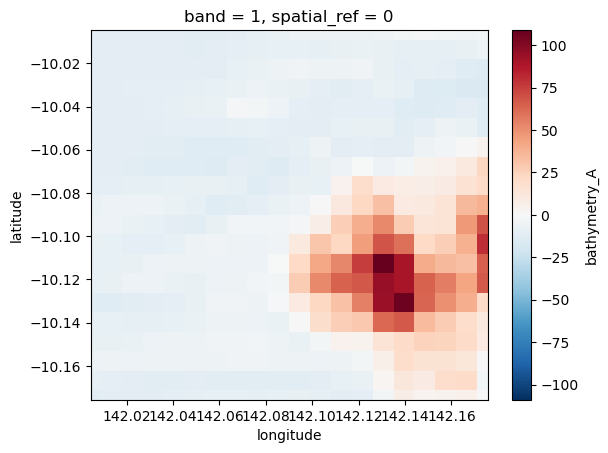

In [291]:
bath_res_climate_test_chunk["bathymetry_A"].plot()

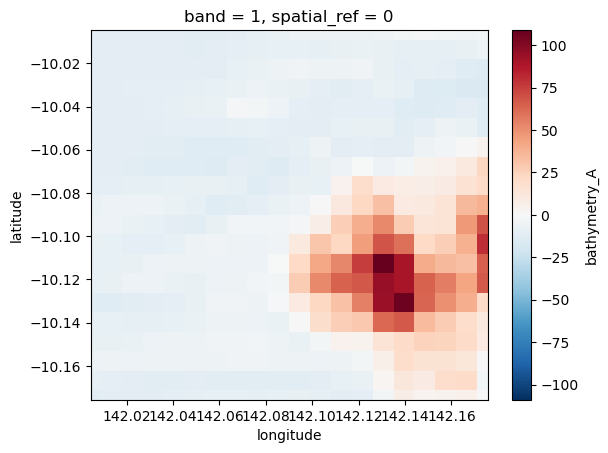

In [271]:
interped = test_chunk.interp(latitude=restricted_bath["latitude"], longitude=restricted_bath["longitude"], method="nearest")
interped["bathymetry_A"].plot()

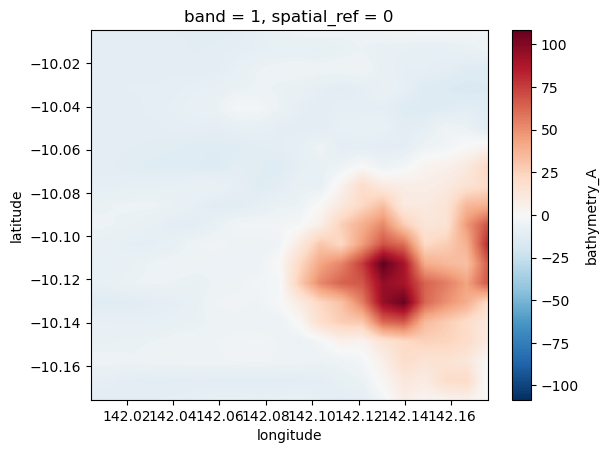

In [266]:
# Reindex the ds_9km dataset to match the coordinates of restricted_bath
ds_9km_reindexed = test_chunk.reindex(latitude=restricted_bath.latitude, longitude=restricted_bath.longitude, method="nearest")

# Repeat the values of ds_9km for each 30 meter cell
# ds_9km_repeated = ds_9km_reindexed.repeat(restricted_bath.dims["latitude"], axis=0).repeat(restricted_bath.dims["longitude"], axis=1)

# Expand the dimensions of ds_9km to match the shape of restricted_bath
expanded_ds_9km = ds_9km_reindexed.expand_dims(latitude=restricted_bath.dims["latitude"], longitude=restricted_bath.dims["longitude"])

# Repeat the values of ds_9km for each 30 meter cell using broadcasting
ds_9km_repeated = expanded_ds_9km.broadcast_like(restricted_bath)

# Combine the datasets into a new dataset
combined_ds = xr.concat([restricted_bath, ds_9km_repeated], dim="variable")

ValueError: Dimension latitude already exists.

In [244]:
test_chunk

<xarray.Dataset>
Dimensions:       (longitude: 20, latitude: 20)
Coordinates:
    band          int64 ...
  * longitude     (longitude) float64 142.0 142.0 142.0 ... 142.2 142.2 142.2
  * latitude      (latitude) float64 -10.0 -10.01 -10.02 ... -10.17 -10.18
    spatial_ref   int64 ...
Data variables:
    bathymetry_A  (latitude, longitude) float32 ...

In [ ]:
bath_1_12_degree = spatial_data.upsample_xarray_to_target(bath_A, 1/12)

bath_1_12_degree.values[0,:,:].shape

In [ ]:
min_max_index_extreme_values(bath_1_12_degree.sel(latitude=slice(-12,-15)))

In [ ]:
bath_1_12_degree

In [ ]:
monthly_climate.sel(latitude=slice(-10,-17.05), longitude=slice(141.95,147.05))

In [ ]:
no_band_bath = bath_1_12_degree.isel(band=0)

# downsample climate data to 1km
monthly_climate = ds_man.get_dataset("monthly_climate_1_12")

# get limits of bathymetry
lat_lims = spatial_data.xarray_coord_limits(bath_1_12_degree, "latitude")
lon_lims = spatial_data.xarray_coord_limits(bath_1_12_degree, "longitude")

restricted_monthly_climate = monthly_climate.sel(latitude=slice(-10,-17), longitude=slice(142,147))


# padded_restricted_monthly_climate = spatial_data.buffer_nans(restricted_monthly_climate, size=1
km_monthly = restricted_monthly_climate.interp_like(bath_1_12_degree, method="linear")

coral_climate_1km = xa.combine_by_coords([km_monthly.drop("spatial_ref"),no_band_bath], coords=["time", "latitude", "longitude"])
(coral_climate_1km,) = xa.broadcast(coral_climate_1km)
coral_climate_1km

In [ ]:
restricted_monthly_climate

In [ ]:
# TODO: fix ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (13,) + inhomogeneous part.

# train_comb_Xs, train_comb_ys, train_comb_subsample, train_comb_lat_lons_vals_dict = generate_patch(xa_ds=coral_climate_1km, lat_lon_starts=(-10,142), coord_range=(-6,6))
# test_comb_Xs, test_comb_ys, test_comb_subsample, test_comb_lat_lons_vals_dict = generate_patch(xa_ds=coral_climate_1km, lat_lon_starts=(-16,148), coord_range=(-6,6))

In [ ]:
print("all_Xs_onehot shape: ", all_Xs_onehot.shape)
print("all_ys_onehot shape: ", all_ys_onehot.shape)

In [ ]:
# TODO: normalise along variable axes

In [ ]:
all_Xs, all_lat_lon_dict = sample_spatial_batch(xa_coral_climate_1_12, lat_lon_starts=(-8,140), coord_range=(-20,13))
all_Xs, all_lat_lon_dict = subsample_to_array(xa_coral_climate_1_12, lat_lon_starts=(-8,140), coord_range=((-20,13)))
all_Xs = naive_X_nan_replacement(all_Xs)
all_ys, _ = subsample_to_array(xa_coral_climate_1_12, lat_lon_starts=(-10,142), coord_range=(-7,5), variables = ["coral_algae_1-12_degree"])
all_ys = naive_y_nan_replacement(all_ys)
all_ys = all_ys[:,:,0]

In [ ]:
print("Xs shape: ", Xs.shape)
print("ys shape: ", ys.shape)

In [ ]:
Xs, ys, all_subsample, all_lat_lons_vals_dict = generate_patch(xa_coral_climate_1_12, lat_lon_starts=(-10,142), coord_range=(-7,5))
patch1_Xs, patch1_ys, patch1_subsample, patch1_lat_lons_vals_dict = generate_patch(xa_coral_climate_1_12, (-10,142), (-7,5))
patch2_Xs, patch2_ys, patch2_subsample, patch2_lat_lons_vals_dict = generate_patch(xa_coral_climate_1_12, (-17,147), (-7,5))
patch3_Xs, patch3_ys, patch3_subsample, patch3_lat_lons_vals_dict = generate_patch(xa_coral_climate_1_12, (-16,146), (-7,5))



In [ ]:
dailies_combined = xa.open_dataset("/Volumes/MRes Drive/global_ocean_reanalysis/daily/dailies_combined.nc").isel(depth=0)
monthly = xa.open_dataset("/Volumes/MRes Drive/global_ocean_reanalysis/monthly_means/baseline_area/coral_climate_1_12.nc")
coral_gt, lat_lon_A_vals_dict = spatial_data.sample_spatial_batch(
       monthly["coral_algae_1-12_degree"], lat_lon_starts=(-10,141.95), coord_range=(-7.01,5.11))

dailies_combined["coral_algae_1-12_degree"] = coral_gt.isel(time=0)
(dailies_combined,) = xa.broadcast(dailies_combined)

In [ ]:
coral_gt.isel(time=0)

In [ ]:
dailies_combined

In [ ]:
dailies_combined["coral_algae_1-12_degree"] = coral_gt.isel(time=0)
(dailies_combined,) = xa.broadcast(dailies_combined)

In [ ]:
dailies_combined

In [ ]:
# really slow, even when ds isn't particularly large (5185, 9863, 8): probably due to ds.to_array().values
# in xa_d_to_np_array
(daily_Xs, daily_ys), daily_subsample, daily_lat_lons_vals_dict = spatial_data.generate_patch(
    xa_ds=daily_climate_1_12, lat_lon_starts=(-17,142), coord_range=(7,5))

In [ ]:
print("Xs shape: ", daily_Xs.shape)
print("ys shape: ", daily_ys.shape)

In [ ]:
X_train = daily_Xs[:]
y_train = daily_ys[:]

wandb.init(
    project="coralshift",
    entity="orlando-code",
    settings=wandb.Settings(start_method="fork")
    # config={    }
    )

# initialize optimiser: will need hyperparameter scan for learning rate and others
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
optimizer = tf.keras.optimizers.Adam(3e-4)

# X = ds_man.get_dataset("monthly_climate_1_12_X_np")
# y = ds_man.get_dataset("monthly_climate_1_12_y_np")
# # check that untrained model runs (should output array of non-nan values)
# # why values change?
# # g_model(X[:32])

# X_train, X_test, y_train, y_test = model_selection.train_test_split(
#     X, y, test_size=0.2, random_state=42)

# X_train, X_test, y_train, y_test = model_selection.train_test_split(
#     sub_X, sub_y, test_size=0.2, random_state=42)

# Define Gated Recurrent Unit model class in TensorFlow
class gru_model(tf.keras.Model):
    # initialise class instance to define layers of the model
    def __init__(self, rnn_units: list[int], num_layers: int, 
        # dff: int
        ):
        """Sets up a GRU model architecture with multiple layers and dense layers for mapping the outputs of the GRU 
        layers to a desired output shape

        Parameters
        ----------
        rnn_units (list[int]): list containing the number of neurons to use in each layer
        num_layers (int): number of layers in GRU model
        """
        super(gru_model, self).__init__()   # initialise GRU model as subclass of tf.keras.Model
        # store values for later use
        self.num_layers = num_layers    # number of layers in GRU model
        self.rnn_units = rnn_units
        # self.dff = dff
        # define model layers: creating new `tf.keras.layers.GRU` layer for each iteration
        self.grus = [tf.keras.layers.GRU(rnn_units[i],  # number (integer) of rnn units/neurons to use in each model layer
                                   return_sequences=True,   # return full sequence of outputs for each timestep
                                   return_state=True) for i in range(num_layers)] # return last hidden state of RNN at end of sequence
        
        # dense layers are linear mappings of RNN layer outputs to desired output shape
        # self.w1 = tf.keras.layers.Dense(dff) # 10 units
        self.w1 = tf.keras.layers.Dense(10) # 10 units

        self.w2 = tf.keras.layers.Dense(1)  # 1 unit (dimension 1 required before final sigmoid function)
        # self.A = tf.keras.layers.Dense(30)
        # self.B = tf.keras.layers.Dense(dff)



    def call(self, inputs: np.ndarray, training: bool=False):
        """Processes an input sequence of data through several layers of GRU cells, followed by a couple of
        fully-connected dense layers, and outputs the probability of an event happening.
        
        Parameters
        ----------
        inputs (np.ndarray): input tensor of shape (batch_size, seq_length, features)
            batch_size - defines the size of the sample drawn from datapoints
            seq_length - number of timesteps in sequence
            features - number of features associated with each datapoint
        training (bool, defaults to False): True if model is in training, False if in inference mode

        Returns
        -------
        target: probability of an event occuring, with shape (batch_size, 1)
        """
        # input shape: (batch_size, seq_length, features)
       
        assert self.num_layers == len(self.rnn_units)

        # check that input tensor has correct shape
        if (len(inputs.shape) != 3):
            print(f"Incorrect shape of input tensor. Expected 3D array. Recieved {len(inputs.shape)}D array.")

        # print('input dim ({}, {}, {})'.format(inputs.shape[0], inputs.shape[1], inputs.shape[2]))
        # whole_seq, static_input = inputs
        whole_seq = inputs


        # iteratively passes input tensor to GRU layers, overwritting preceding sequence 'whole_seq'
        for layer_num in range(self.num_layers):
            whole_seq, final_s = self.grus[layer_num](whole_seq, training=training)

        # adding extra layers
        # static = self.B(tf.nn.gelu(self.A(static_input)))
        # target = self.w1(final_s)  + static # final hidden state of last layer used as input to fully connected dense layers...
        target = self.w1(final_s)   # final hidden state of last layer used as input to fully connected dense layers...

        target = tf.nn.relu(target) # via ReLU activation function
        target = self.w2(target)    # final hidden layer must have dimension 1 
        
        # obtain a probability value between 0 and 1
        target = tf.nn.sigmoid(target)
        
        return target


# initialise GRU model with 500 hidden layers, one GRU unit per layer 
g_model = gru_model([100], 1) # N.B. [x] is number of hidden layers in GRU network


def negative_log_likelihood(y: np.ndarray, y_pred: np.ndarray, class_weights: np.ndarray = None) -> float:
    """Compute binary cross-entropy loss between ground-truth binary labels and predicted probabilities,
    incorporating class weights.

    Parameters
    ----------
    y (np.ndarray): true binary labels, where 0 represents the negative class
    y_pred (np.ndarray): predicted labels (as probability value between 0 and 1)
    class_weights (np.ndarray): weights for each class. If None, no class weights will be applied.

    Returns
    -------
    float: negative log likelihood loss computed using binary cross-entropy loss between 'y' and 'y_pred',
    incorporating class weights if provided
    """
    bce = tf.keras.losses.BinaryCrossentropy()  

    if class_weights is not None:
        sample_weights = tf.gather(class_weights, np.asarray(y,dtype=np.int32))
        return bce(y, y_pred, sample_weight=sample_weights)

    return bce(y, y_pred)


def training_batches(X: np.ndarray, y: np.ndarray, batch_num: int, batch_size: int=32):
    start_idx = batch_num * batch_size
    end_idx = (batch_num + 1) * batch_size

    X_batch = X[start_idx:end_idx]
    y_batch = y[start_idx:end_idx]
    
    return X_batch, y_batch

# https://stackoverflow.com/questions/52357542/attributeerror-tensor-object-has-no-attribute-numpy
# should aim to delete the following to speed up training: but can't figure out a way to make wandb reporting work
# without it
tf.config.run_functions_eagerly(True)

def build_graph():
    
    # compile function as graph using tf's autograph feature: leads to faster execution times, at expense of limitations
    # to Python objects/certain control flow structures (somewhat relaxed by experimental_relax_shapes)
    @tf.function(experimental_relax_shapes=True)
    def train_step(gru: tf.keras.Model, optimizer: tf.keras.optimizers.Optimizer, X: np.ndarray, y: np.ndarray, 
        training: bool=True, class_weights=class_weights, batch_num:int=None, batch_size: int=None) -> tuple[np.ndarray, float]:
        """Train model using input `X` and target data `y` by computing gradients of the loss (via 
        negative_log_likelihood)
        
        Parameters
        ----------
        y (np.ndarray): true binary labels, where 0 represents the negative class
        y_pred (np.ndarray): predicted labels (as probability value between 0 and 1)

        Returns
        -------
        float: negative log likelihood loss computed using binary cross-entropy loss between 'y' and 'y_pred'
        """
        if training:
            num_samples = X.shape[0]
            num_batches = num_samples // batch_size
            # num_batches = batch_num
            total_epoch_loss = 0.0
            for batch_num in tqdm(range(num_batches), desc="batches", position=0, leave=True):
                X_batch, y_batch = training_batches(X, y, batch_num=batch_num, batch_size=batch_size)

                with tf.GradientTape(persistent=True) as tape:
                    y_pred = gru(X_batch, training) 
                    xent = negative_log_likelihood(y_batch, y_pred, class_weights)
                    # y_pred = gru(X, training) # TO DELETE
                    # xent = negative_log_likelihood(y, y_pred)
                
                gradients = tape.gradient(xent, gru.trainable_variables)
                optimizer.apply_gradients(zip(gradients, gru.trainable_variables))
                # print("xent", xent.numpy())
                # print("total_epoch_loss", total_epoch_loss)
                total_epoch_loss += xent
                # learning rate?
                wandb.log({"batch": batch_num, "loss": xent, "total_epoch_loss": total_epoch_loss})

            average_loss = total_epoch_loss / num_batches
            # return predicted output values and total loss value
            return y_pred, xent, total_epoch_loss

    # set default float type
    tf.keras.backend.set_floatx('float32')
    # TODO: this isn't assigned... What should it return otherwise?
    return train_step



class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=np.reshape(y_train,-1))

with tf.device("/GPU:0"):
    num_epochs = 10
    # will update so that subsamples are fed in from which batches are taken: will require recomputation
    # of class_weight for each subsample
    num_batches = 2
    batch_size = 128
    tr_step = build_graph()
    for epoch in tqdm(range(num_epochs), desc= " epochs", position = 0, leave=True):
        y_pred, xent, total_epoch_loss = tr_step(
            g_model, optimizer, X_train[:], y_train[:], class_weights=class_weights, 
            batch_size=batch_size, batch_num=num_batches, training=True)
        wandb.log({"epoch": epoch, "epoch_loss": total_epoch_loss})

wandb.finish()

# check (with prints) that wandb is functioning
# check against known timeseries task for correct implementation
# find timeseries which get bad loss and debug why
# log best loss which can be logged: save weights (and do a inference plot with best weights)

In [ ]:
(daily_subsample_Xs, daily_subsample_ys), daily_subsample, daily_subsample_lat_lon_vals_dict = spatial_data.generate_patch(xa_ds=daily_climate_1_12, lat_lon_starts=(-17,144), coord_range=(3,3))

# sample, ll_dict = spatial_data.sample_spatial_batch(xa_ds=daily_climate_1_12, lat_lon_starts=(-17,145), coord_range=(-2,2))

In [ ]:
arr=[0,1,2,3,4,5]
for i in range(0,3):
    print(arr[:-i or None])

In [ ]:
daily_subsample_Xs.shape

In [ ]:
### train/predict
# if training:
    # assign epoch output to dataset
# if testing:
# patch1_pred = g_model(patch1_Xs, training=False)
# patch2_pred = g_model(patch2_Xs, training=False)
# patch3_pred = g_model(patch3_Xs, training=False)
pred = g_model(daily_subsample_Xs, training=False)

# all_predicted = g_model(all_Xs, training=False)
    # assign output predictions to dataset

In [ ]:
patch = spatial_data.reformat_prediction(daily_climate_1_12, daily_subsample, pred, daily_subsample_lat_lon_vals_dict)
spatial_plots.plot_var(patch["output"])


In [ ]:
patch_pred_xa_ds_onehot_lim = reformat_prediction(xa_coral_climate_1_12_working, test_onehot_subsample, pred, test_onehot_lat_lons_vals_dict)

mask = patch_pred_xa_ds_onehot_lim["output"] > 0.6

spatial_plots.plot_var(mask)

In [ ]:
patch_pred_xa_ds_onehot_lim = reformat_prediction(xa_coral_climate_1_12_working, test_onehot_subsample, pred, test_onehot_lat_lons_vals_dict)

spatial_plots.plot_var(patch_pred_xa_ds_onehot_lim["output"])



In [ ]:
patch_Xs_onehot, patch_ys_onehot, patch_subsample_onehot, patch_lat_lons_vals_dict_onehot = generate_patch(xa_coral_climate_1_12, (-10,142), (-7,5))

patch_pred_xa_ds_onehot = reformat_prediction(xa_coral_climate_1_12_working, patch_subsample_onehot, pred, patch_lat_lons_vals_dict_onehot)

spatial_plots.plot_var(patch_pred_xa_ds_onehot["output"])


In [ ]:
np.array_equal(patch1_pred_xa_ds["output"].values,patch2_pred_xa_ds["output"])

In [ ]:
# patch1_pred_xa_ds = reformat_prediction(xa_coral_climate_1_12_working, patch1_subsample, patch1_pred, patch1_lat_lons_vals_dict)
# patch2_pred_xa_ds = reformat_prediction(xa_coral_climate_1_12_working, patch2_subsample, patch2_pred, patch2_lat_lons_vals_dict)
# patch3_pred_xa_ds = reformat_prediction(xa_coral_climate_1_12_working, patch3_subsample, patch3_pred, patch3_lat_lons_vals_dict)


f, a0 = spatial_plots.plot_var_at_time(xa_coral_climate_1_12["coral_algae_1-12_degree"], "2020-12-16")
# # visualise result
# spatial_plots.plot_var(patch1_pred_xa_ds["output"])
# spatial_plots.plot_var(patch2_pred_xa_ds["output"])
# spatial_plots.plot_var(patch3_pred_xa_ds["output"])

# pred_xa_ds["coral_algae_1-12_degree"].isel(time=-1).plot(ax=ax[0])
# pred_xa_ds["output"].plot(ax=ax[1])


In [ ]:
xa_coral_climate_1_12["bottomT"].isel(time=-1).plot()

# Adding in bathymetry

In [ ]:
# downsample climate data to 1km
monthly_climate = ds_man.get_dataset("monthly_climate_1_12")

# get limits of bathymetry
lat_lims = spatial_data.xarray_coord_limits(coarsened_bath_A, "latitude")
lon_lims = spatial_data.xarray_coord_limits(coarsened_bath_A, "longitude")

restricted_monthly_climate = monthly_climate.sel(latitude=slice(-10,-17), longitude=slice(142,147))


# padded_restricted_monthly_climate = spatial_data.buffer_nans(restricted_monthly_climate, size=1

In [ ]:
buffer_size = 3
exclude_vars = ["spatial_ref", "coral_algae_1-12_degree", "siconc", "usi", "vsi", "sithick"]
buffered_ds = spatially_buffer_timeseries(monthly_climate, buffer_size=buffer_size, exclude_vars=exclude_vars)

buffered_ds.to_netcdf(
    ds_man.get_location() / f"global_ocean_reanalysis/monthly_means/monthly_climate_{buffer_size}_buffer.nc")

In [ ]:
buffered_ds

In [ ]:
f,a = plt.subplots(1,2, figsize=[10,5])
monthly_climate["mlotst"].isel(time=99).plot(ax=a[0], cmap="jet")
buffer_attempt["mlotst"].isel(time=99).plot(ax=a[1],cmap="jet")

In [ ]:
coral_climate_1km

In [ ]:
buffer_attempt.equals(monthly_climate.isel(time=slice(0,2)))

In [ ]:
buffer_attempt.isel(time=1)["mlotst"].plot()

In [ ]:
coarsened_bath_A.isel(band=0)

In [ ]:
coral_climate_1km["bathymetry_A"]

In [ ]:
monthly_climate

In [ ]:
f,a = plt.subplots(1,2, figsize=[10,5])
coral_climate_1km.isel(time=-1)["bathymetry_A"].plot(ax=a[0], vmin=-100, vmax=0)
coral_climate_1km.isel(time=-1)["mlotst"].plot(ax=a[1])

In [ ]:
# attempt.isel(time=-1)["mlotst"].plot()
eg_data = buffer_attempt.isel(time=-1)["mlotst"]

spatial_plots.plot_DEM(eg_data, f" DEM upsampled to {target_resolution} meters", 
    landmask=False, vmin=np.nanmin(eg_data.values), vmax=np.nanmax(eg_data.values), cmap="jet")

In [ ]:
# TESTING

# for longitude in array
# get 
sub_X.shape

In [ ]:
X.shape

In [ ]:
wandb.finish()

In [ ]:
# TODO: optionally replace batching with spatial batching

### Test GRU functions

In [ ]:
print(tf.config.list_physical_devices())
!nvidia-smi

In [ ]:
with tf.device("/GPU:0"):
    num_epochs = 5
    num_batches = 100
    tr_step = build_graph()
    for epoch in tqdm(range(num_epochs), desc= " epochs", position = 0):
        y_pred, average_loss = tr_step(g_model, optimizer, X_train[:1000], y_train[:1000], batch_size=32, training=True)
        
        
        
        # for batch in range(num_batches):
        #     array, y  = batcher_fun(X, 32, 276 
        #     #training = True)# shapes: (batch_s, seq_l, features), (batch_s, 1)
        #     )
        #     y_pred, xent = tr_step(g_model, optimizer, X[:32], y, training=True)
            
        #  ## validation set 
        #  ## test_set 

In [ ]:
# negative_log_likelihood(y_test,g_model(X_test))
y_test=y_test[:1000]
y_pred = g_model(X[:1000])

In [ ]:
plt.scatter(y_test,y_pred.numpy())

In [ ]:
# made unnecssary due to isel indexing
# def pixels_to_coord_diff(xa_ds: xa.Dataset | xa.DataArray, window_dim: int, coord: str) -> list[float, float]:
#     return float(window_dim * np.diff(spatial_data.min_max_of_coords(xa_ds, coord)) / len(list(xa_coral_climate_1_12[coord])))

In [ ]:
subsample["bottomT"].isel(time=-1).plot()

In [ ]:
sample_spatial_batch(xa_coral_climate_1_12,lat_lon_starts=(-16,144), coord_range=(-4,2))["coral_algae_1-12_degree"]

In [ ]:
xa_coral_climate_1_12_working = xa_coral_climate_1_12

In [ ]:
# [lat_lon_vals_dict.items() for key in ["latitude", "longitude"]]
{key: lat_lon_vals_dict[key] for key in ["latitude", "longitude"]}

In [ ]:
sub_y_nans.shape

In [ ]:
(list(subsample.data_vars))

In [ ]:
# TODO: fix boolean indexing
# # For now, shallowest depth is taken (0.45)
# # TODO: process this and export it to new file since takes a while to run
# ds_man.add_dataset(
#     "daily_climate_1_12_X_np", filter_out_nans(
#         spatial_data.xa_ds_to_3d_numpy(ds_man.get_dataset("daily_climate_1_12").isel(depth=0)), ds_man.get_dataset("daily_climate_1_12_y_np"))[0]
# )

In [ ]:
# TODO: put this merge into data processing pipeline
# merge daily mean files
# var_daily_dir = Path("lustre_scratch/datasets/global_ocean_reanalysis/daily_means")
# save_combined_dailies_path = Path("lustre_scratch/datasets/global_ocean_reanalysis/daily_means/dailies_combined.nc")
# daily_file_paths = file_ops.return_list_filepaths(var_daily_dir, ".nc")
# combined_dailies = xa.open_mfdataset(daily_file_paths)
# combined_dailies.to_netcdf(save_combined_dailies_path)

In [ ]:
# # create 3D array from xarray dataset variables. Shape: (num_samples, num_parameters, sequence_len)
# X_with_nans = spatial_data.xa_ds_to_3d_numpy(xa_coral_climate_1_12_features)
# print(f'X_with_nans shape (num_samples: {X_with_nans.shape[0]}, total num_parameters (includes nans parameters): {X_with_nans.shape[1]}, sequence_len: {X_with_nans.shape[2]})')

# for i, param in enumerate(xa_coral_climate_1_12_features.data_vars):
#     print(f"{i}: {param}")

#### Remove observations for which there are nan values

99% sure these are are just gridcells containing land. Would be a good thing to investigate, however.

In [ ]:
# X = X_with_nans
# # problem, probably with sea ice features

In [ ]:
# # filter out columns that contain entirely NaN values
# col_mask = ~np.all(np.isnan(X), axis=(0,2)) # boolean mask indicating which columns to keep
# masked_cols = X[:, col_mask, :] # keep only the columns that don't contain entirely NaN values
# print("masked_cols shape:", masked_cols.shape)

In [ ]:
# # filter out all rows which contain any NaN values
# row_mask = ~np.any(np.isnan(masked_cols), axis=1) # boolean mask indicating which rows to keep
# masked_cols_rows = masked_cols[row_mask[:,0], :, :] # keep only the rows that don't contain any NaN values
# masked_cols_rows.shape

In [ ]:
# # filter out all depths which contain any NaN values
# depth_mask = ~np.any(np.isnan(masked_cols_rows), axis=(0,1)) # boolean mask indicating which depths to keep
# X = masked_cols_rows[:, :, depth_mask] # keep only the depths that don't contain any NaN values
# X = np.swapaxes(X, 1, 2)
# print(f"X shape: {X.shape}")

In [ ]:
# # create target from coral ground truth. Shape: (num_samples, 1)
# # TODO: not sure if this is shuffling the values when reshaping
# y_with_nans = np.array(xa_coral_climate_1_12["coral_algae_1-12_degree"].sel(
#     time=xa_coral_climate_1_12.time[-1])).reshape(-1, 1)
# # remove ys with nan values in other variables
# y = y_with_nans[row_mask[:,0]]

# print(f"y_with_nans shape: {y_with_nans.shape}")
# print(f"y shape: {y.shape}")

In [ ]:
# X, y = filter_out_nans(X_with_nans, np.array(xa_coral_climate_1_12["coral_algae_1-12_degree"].isel(time=-1)).reshape(-1, 1))
# print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")

In [ ]:
# X.shape

In [ ]:
# sub_X = np.moveaxis(np.array(test_array), 2, 1)
sub_X.shape

In [ ]:
col_mask = ~np.all(np.isnan(test_array), axis=(0,2))
sub_X = test_array[:, col_mask, :]

In [ ]:
sub_X.shape

In [ ]:
xa_coral_climate_1_12_features = ds_man.get_dataset("monthly_climate_features")
xa_coral_climate_1_12 = ds_man.get_dataset("monthly_climate_1_12")

In [ ]:
Xs, lat_lon_dict = subsample_to_array(xa_coral_climate_1_12, lat_lon_starts=(-10,142), coord_range=(-7,5))
Xs_nonans = naive_X_nan_replacement(Xs)
ys, _ = subsample_to_array(xa_coral_climate_1_12, lat_lon_starts=(-10,142), coord_range=(-7,5), variables = ["coral_algae_1-12_degree"])
ys = ys[:,:,0]

In [ ]:
ys.shape

In [ ]:
# sample subset
# subsample, lat_lon_vals_dict = sample_spatial_batch(xa_coral_climate_1_12_features,lat_lon_starts=(-12,144), coord_range=(-4,2))
# subsample, lat_lon_vals_dict = sample_spatial_batch(xa_coral_climate_1_12_features,lat_lon_starts=(-10,142), coord_range=(-7,5))
# convert to ndarray
# # test_array = spatial_data.xa_ds_to_3d_numpy(subsample)
# # subsample_all, _ = sample_spatial_batch(xa_coral_climate_1_12,lat_lon_starts=(-16,144), coord_range=(-4,2))
# subsample_all, _ = sample_spatial_batch(xa_coral_climate_1_12,lat_lon_starts=(-10,142), coord_range=(-7,5))
# sub_y_nans = (np.array(subsample_all["coral_algae_1-12_degree"].isel(time=-1))).reshape(-1, 1)
# # remove nans
# #sub_X, sub_y = filter_out_nans(test_array, sub_y_nans)
# # testing, so replace nans with -1
# # filter out columns that contain entirely NaN values
# # col_mask = ~np.all(np.isnan(test_array), axis=(0,2)) # boolean mask indicating which columns to keep
# # sub_X = test_array[:, col_mask, :] # keep only the columns that don't contain entirely NaN values

# # sub_X = np.moveaxis(np.array(sub_X), 2, 1)
# sub_y = sub_y_nans
# # sub_X[np.isnan(sub_X)] = -10000
# sub_y[np.isnan(sub_y)] = -10000




In [ ]:
def subset_to_dataset_var(xa_ds: xa.Dataset | xa.DataArray, subset_vals: np.ndarray, dims: list=['latitude', 'longitude', "time"]):

In [ ]:
predicted

In [ ]:
test_x_train = np.append(100*np.ones((50,50,5)), 1*np.ones((50,50,5)), 0)
test_y_train = np.append(np.ones(50,), np.zeros(50,))


print("test_x_train:", test_x_train.shape)
# print("x_test:", x_test.shape)
print("test_y_train:", test_y_train.shape)
# print("y_test:", y_test.shape)


In [ ]:
array = np.random.normal(size = (32, 20, 1))    # shape: (num_samples, sequence_length, num_features)
y_dud = np.random.choice([0, 1], size = 32)
print("array shape:", array.shape)
print("y_dud shape:", y_dud.shape)

x_train, y_train = X[:500], y[:500].reshape(500,)
# x_test, y_test = X[5000:6000], y[5000:6000].reshape((1000,))

print("x_train:", x_train.shape)
# print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
# print("y_test:", y_test.shape)


In [ ]:
plt.plot(g_model(test_x_train[:],training=False).numpy())

In [ ]:
predicted = g_model(X[:5610],training=False)

In [ ]:
X.shape

In [ ]:
xa_coral_climate_1_12["coral_algae_1-12_degree"].isel(time=-1)

In [ ]:
30*187

In [ ]:
fig, ax = plt.subplots()
out = ax.imshow(predicted.numpy().reshape(30,187))
fig.colorbar(out, ax=ax)

In [ ]:
np.sqrt(500)

In [ ]:
xa_coral_climate_1_12_features

In [ ]:
xa_coral_climate_1_12["coral_algae_1-12_degree"].isel(time=-1)

In [ ]:
fig, ax = plt.subplots()
out = ax.imshow(y_pred.numpy().reshape(20,25))
fig.colorbar(out, ax=ax)

In [ ]:
sum((y_pred > 0.5).numpy())

In [ ]:
# check log likelihood is computable
negative_log_likelihood(y[:32], g_model(X[:32]))

## Train and test GRU

In [ ]:
# define batcher function (by space and time)

In [ ]:
def batcher_fun(X, y, batch_size, seq_len):
    """
    A function to prepare the data for training the LSTM.
    
    :param data: The input data to the LSTM.
    :param batch_size: The number of samples in each batch.
    :param seq_len: The sequence length of each sample.
    
    :return: A tuple of (batch_x, batch_y), where batch_x is a numpy array of shape (batch_size, seq_len, num_features) 
             and batch_y is a numpy array of shape (batch_size, num_classes).
    """
    num_samples = len(data)
    num_batches = int(num_samples / batch_size)
    num_features = spatial_data.shape[1]
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        
        batch_x = np.zeros((batch_size, seq_len, num_features))
        batch_y = np.zeros((batch_size, 1))
        
        for j in range(start_idx, end_idx):
            sample = data[j]
            X = sample[:-1]
            y = y[]
            
            batch_x[j - start_idx] = x.reshape((seq_len, num_features))
            batch_y[j - start_idx, y] = 1
            
        yield batch_x, batch_y


In [ ]:
with tf.device("/CPU:0"):
    num_epochs = 1
    num_batches = 100
    tr_step = build_graph()
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            array, y  = batcher_fun(X, 32, 276 
            #training = True)# shapes: (batch_s, seq_l, features), (batch_s, 1)
            )
            y_pred, xent = tr_step(g_model, optimizer, X[:32], y, training=True)
            
         ## validation set 
         ## test_set 

In [ ]:
y_pred

# Copypasta

[Source](https://github.com/christianversloot/machine-learning-articles/blob/main/build-an-lstm-model-with-tensorflow-and-keras.md)

In [ ]:
X.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam # https://stackoverflow.com/questions/75356826/attributeerror-adam-object-has-no-attribute-get-updates
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model configuration
additional_metrics = ["accuracy"]
# batch_size = 128
batch_size = 32
# embedding_output_dims = 15
# embedding_output_dims = 10
loss_function = BinaryCrossentropy()
# max_sequence_length = 300
max_sequence_length = 276
# num_distinct_words = 5000
# num_distinct_words = 10000
number_of_epochs = 5
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [ ]:
# Load dataset
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)
x_train, y_train = X[:5000], y[:5000].reshape((5000,))
x_test, y_test = X[5000:6000], y[5000:6000].reshape((1000,))

print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

In [ ]:
# Pad all sequences: keras requires sequences of equal lengths. Should be handled in pre-processing, but here for now for security
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

# (number_samples, sequence_length, num_features)
print("padded_inputs:", padded_inputs.shape)
print("padded_inputs_test:", padded_inputs_test.shape)

In [ ]:
padded_inputs = pad_sequences(x_train[:,:,0], maxlen=max_sequence_length, value = 0.0)
padded_inputs_test = pad_sequences(x_test[:,:,0], maxlen=max_sequence_length, value = 0.0)

# (number_samples, sequence_length)
print("padded_inputs:", padded_inputs.shape)
print("padded_inputs_test:", padded_inputs_test.shape)

In [ ]:
# Define the Keras model
model = Sequential()
model.add(
    Embedding(
        num_distinct_words+1, embedding_output_dims, input_length=max_sequence_length
    )
)
model.add(LSTM(10))
model.add(Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

# Give a summary
model.summary()

In [ ]:
y_train.shape

In [ ]:
# Train the model
history = model.fit(
    padded_inputs,
    y_train,
    batch_size=batch_size,
    epochs=number_of_epochs,
    verbose=verbosity_mode,
    validation_split=validation_split,
)

# Test the model after training
test_results = model.evaluate(padded_inputs_test, y_test, verbose=False)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%")

In [ ]:
def plot_score_timeseries(history) -> None:
    fig, ax = plt.subplots()
    ax.plot(history.history["accuracy"])
    ax.plot(history.history["val_accuracy"])

    ax.set_title("Model accuracy against epoch")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend(['train set', 'validation set'], loc='upper left')

plot_score_timeseries(history)

In [ ]:
model.metrics_names

# Multivariate model

[Source](https://medium.com/@canerkilinc/hands-on-multivariate-time-series-sequence-to-sequence-predictions-with-lstm-tensorflow-keras-ce86f2c0e4fa)

In [ ]:
X_toy = X[:32*10,:10,:3]
print("X_toy:", X_toy.shape)
y_toy = y[:32*10]
print("y_toy:", y_toy.shape)


In [ ]:
#import packages
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model
#####################################
#Before do anything else do not forget to reset the backend for the next iteration (rerun the model)
tensorflow.keras.backend.clear_session()
#####################################
# Initialising the LSTM Model with MAE Loss-Function
batch_size = 32
epochs = 120
timesteps = 10
num_features = 3
input_1 = Input(batch_shape=(batch_size,timesteps,num_features))
#each layer is the input of the next layer
lstm_hidden_layer_1 = LSTM(10, stateful=True, return_sequences=True)(input_1)
lstm_hidden_layer_2 = LSTM(10, stateful=True, return_sequences=True)(lstm_hidden_layer_1)
output_1 = Dense(units = 1)(lstm_hidden_layer_2)
regressor_mae = Model(inputs=input_1, outputs = output_1)
#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
#####################################
#Summarize and observe the layers as well as paramter configurations
regressor_mae.summary()

In [ ]:
regressor_mae.fit(
    
)